Universal FSO selected features: ['Distance', 'Temperature', 'Visibility', 'TemperatureMin', 'VisibilityMin', 'ParticulateMax', 'TemperatureMax', 'WindSpeedMax']

Training model for weather condition: Clear Weather
[RF] Best parameters for Clear Weather: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
[FSO] Using universal selected features for Clear Weather: ['Distance', 'Temperature', 'Visibility', 'TemperatureMin', 'VisibilityMin', 'ParticulateMax', 'TemperatureMax', 'WindSpeedMax']
[FSO] Best parameters for Clear Weather: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

Training model for weather condition: Duststorm
[RF] Best parameters for Duststorm: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
[FSO] Using universal selected features for Duststorm: ['Distance', 'Temperature', 'Visibility', 'TemperatureMin', 'VisibilityMin', 'ParticulateMax', 'TemperatureMax', 'Wi

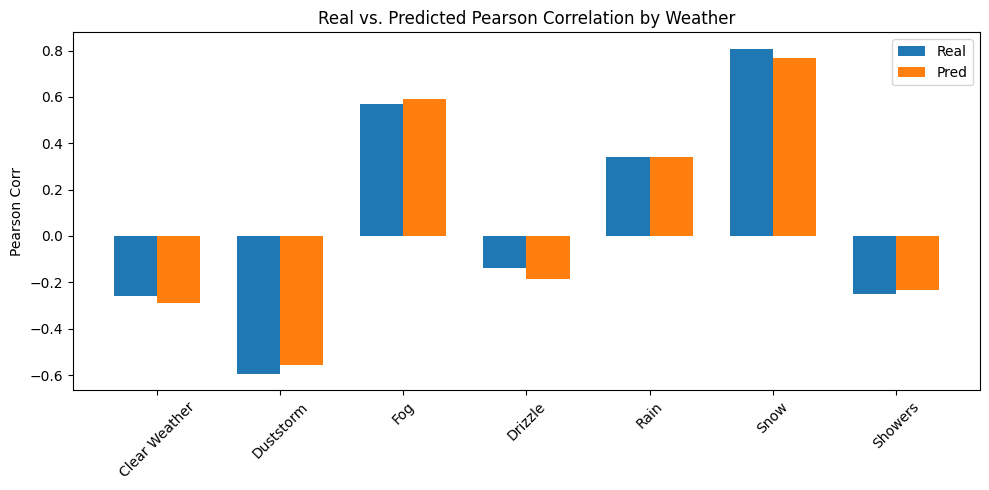

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

data = pd.read_csv("RFLFSODataFull.csv")

weather_mapping = {
    0: 'Clear Weather', 3: 'Duststorm', 4: 'Fog',
    5: 'Drizzle', 6: 'Rain', 7: 'Snow', 8: 'Showers'
}

universal_rf_features = [
    'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'Frequency',
    'TemperatureMax', 'Temperature', 'Distance', 'Visibility'
]

universal_fso_selected_features = [
    'Distance', 'Temperature', 'Visibility', 'TemperatureMin',
    'VisibilityMin', 'ParticulateMax', 'TemperatureMax', 'WindSpeedMax'
]

print("Universal FSO selected features:", universal_fso_selected_features)

X_all = data.drop(["RFL_Att", "FSO_Att"], axis=1)
y_rf_all, y_fso_all = data["RFL_Att"], data["FSO_Att"]

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

results = []
heatmap_data = {}

for code, label in weather_mapping.items():
    subset = data[data['SYNOPCode'] == code]
    if len(subset) < 10:
        continue

    print(f"\nTraining model for weather condition: {label}")

    X = subset.drop(['RFL_Att', 'FSO_Att'], axis=1)
    y_rf, y_fso = subset['RFL_Att'], subset['FSO_Att']
    X_train, X_test, y_rf_train, y_rf_test, y_fso_train, y_fso_test = train_test_split(
        X, y_rf, y_fso, test_size=0.2, random_state=42
    )

    X_train_rf = X_train[universal_rf_features]
    X_test_rf = X_test[universal_rf_features]

    rf_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42), param_distributions=param_dist,
        n_iter=5, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )
    rf_search.fit(X_train_rf, y_rf_train)
    best_rf_model = rf_search.best_estimator_
    print(f"[RF] Best parameters for {label}: {rf_search.best_params_}")

    rf_train_pred = best_rf_model.predict(X_train_rf)
    X_train_fso_input = X_train.drop(columns=['Time', 'SYNOPCode']).copy()
    X_train_fso_input["Predicted_RF_Att"] = rf_train_pred
    X_train_fso = X_train_fso_input[universal_fso_selected_features]

    print(f"[FSO] Using universal selected features for {label}:", universal_fso_selected_features)

    fso_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=42), param_distributions=param_dist,
        n_iter=5, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )
    fso_search.fit(X_train_fso, y_fso_train)
    best_fso_model = fso_search.best_estimator_
    print(f"[FSO] Best parameters for {label}: {fso_search.best_params_}")

    rf_test_pred = best_rf_model.predict(X_test_rf)
    X_test_fso_input = X_test.copy()
    X_test_fso_input["Predicted_RF_Att"] = rf_test_pred
    X_test_fso = X_test_fso_input[universal_fso_selected_features]
    fso_test_pred = best_fso_model.predict(X_test_fso)

    rf_rmse = np.sqrt(mean_squared_error(y_rf_test, rf_test_pred))
    rf_r2 = r2_score(y_rf_test, rf_test_pred)
    fso_rmse = np.sqrt(mean_squared_error(y_fso_test, fso_test_pred))
    fso_r2 = r2_score(y_fso_test, fso_test_pred)

    real_pear_corr, _ = pearsonr(y_rf_test, y_fso_test)
    pred_pear_corr, _ = pearsonr(rf_test_pred, fso_test_pred)

    real_mi = mutual_info_regression(y_rf_test.values.reshape(-1, 1), y_fso_test.values)[0]
    pred_mi = mutual_info_regression(rf_test_pred.reshape(-1, 1), fso_test_pred)[0]
    real_mi_norm = real_mi / np.log(len(y_rf_test))
    pred_mi_norm = pred_mi / np.log(len(rf_test_pred))

    results.append({
        'Weather': label,
        'RF RMSE': rf_rmse,
        'RF R²': rf_r2,
        'FSO RMSE': fso_rmse,
        'FSO R²': fso_r2,
        'Pearson Corr (Real)': real_pear_corr,
        'Pearson Corr (Pred)': pred_pear_corr,
        'Mutual Info (Real)': real_mi_norm,
        'Mutual Info (Pred)': pred_mi_norm
    })

    heatmap_data[label] = {
        'rf_true': y_rf_test.values,
        'rf_pred': rf_test_pred,
        'fso_true': y_fso_test.values,
        'fso_pred': fso_test_pred
    }

results_df = pd.DataFrame(results)
print("\n=== Final Results ===")
print(results_df)

fig, ax = plt.subplots(figsize=(10, 5))
width = 0.35
x = np.arange(len(results_df))
ax.bar(x - width/2, results_df['Pearson Corr (Real)'], width, label='Real')
ax.bar(x + width/2, results_df['Pearson Corr (Pred)'], width, label='Pred')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Weather'], rotation=45)
ax.set_ylabel('Pearson Corr')
plt.title('Real vs. Predicted Pearson Correlation by Weather')
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# 1. 查看是否有每种天气的数据（字典的 key）
print("Keys in heatmap_data:", list(heatmap_data.keys()))

# 2. 查看单个天气的数据结构（必须有 rf_true, rf_pred, fso_true, fso_pred）
if 'Clear Weather' in heatmap_data:
    print("Keys in heatmap_data['Clear Weather']:", list(heatmap_data['Clear Weather'].keys()))
else:
    print("'Clear Weather' is not in heatmap_data")


Keys in heatmap_data: ['Clear Weather', 'Duststorm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']
Keys in heatmap_data['Clear Weather']: ['rf_true', 'rf_pred', 'fso_true', 'fso_pred']


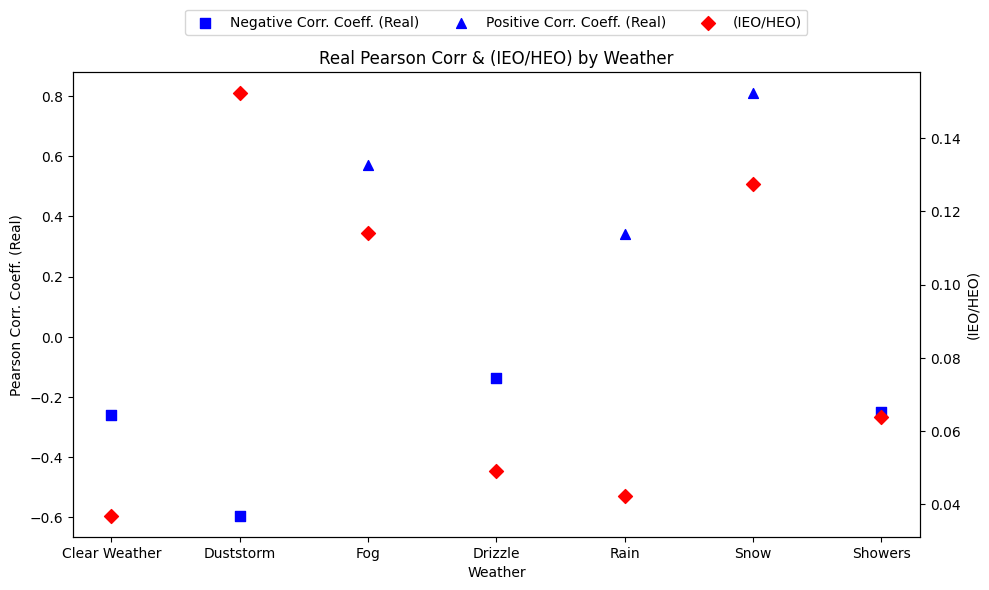

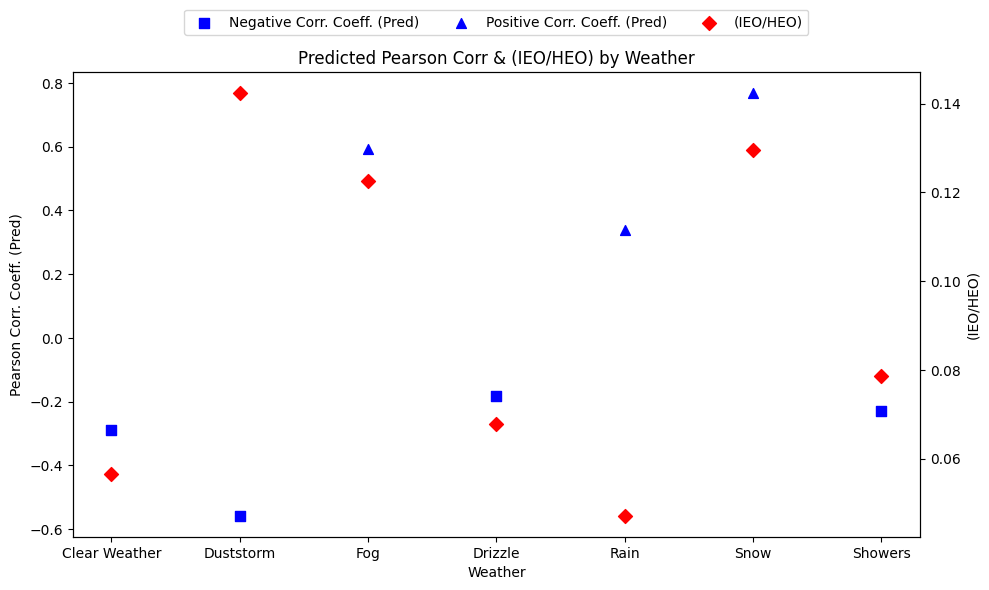

In [ ]:
desired_order = list(weather_mapping.values())
results_df['Weather'] = pd.Categorical(results_df['Weather'], categories=desired_order, ordered=True)
results_df.sort_values('Weather', inplace=True)

weathers = results_df['Weather']
real_corr = results_df['Pearson Corr (Real)']
pred_corr = results_df['Pearson Corr (Pred)']
real_ieo = results_df['Mutual Info (Real)']
pred_heo = results_df['Mutual Info (Pred)']

def plot_corr_and_ieo_heo(ax_corr, ax_ieo, weather_list, corr_vals, ieo_vals,
                          title="", corr_label="", ieo_label="",
                          neg_label="", pos_label="", diamond_label="",
                          markersize=50, rotation=0):

    x = np.arange(len(weather_list))
    shown_neg, shown_pos = False, False

    for i, val in enumerate(corr_vals):
        if val < 0:
            ax_corr.scatter(x[i], val, color='blue', marker='s', s=markersize,
                            label=neg_label if not shown_neg else "")
            shown_neg = True
        else:
            ax_corr.scatter(x[i], val, color='blue', marker='^', s=markersize,
                            label=pos_label if not shown_pos else "")
            shown_pos = True

    ax_ieo.scatter(x, ieo_vals, color='red', marker='D', s=markersize, label=diamond_label)

    ax_corr.set_title(title)
    ax_corr.set_xlabel("Weather")
    ax_corr.set_ylabel(corr_label)
    ax_ieo.set_ylabel(ieo_label)
    ax_corr.set_xticks(x)
    ax_corr.set_xticklabels(weather_list, rotation=rotation)

    handles1, labels1 = ax_corr.get_legend_handles_labels()
    handles2, labels2 = ax_ieo.get_legend_handles_labels()
    combined = list(zip(handles1 + handles2, labels1 + labels2))
    seen, unique = set(), []
    for h, l in combined:
        if l and l not in seen:
            unique.append((h, l))
            seen.add(l)

    ax_corr.legend([u[0] for u in unique], [u[1] for u in unique],
                   loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1_right = ax1.twinx()
plot_corr_and_ieo_heo(
    ax_corr=ax1, ax_ieo=ax1_right,
    weather_list=weathers,
    corr_vals=real_corr,
    ieo_vals=real_ieo,
    title="Real Pearson Corr & (IEO/HEO) by Weather",
    corr_label="Pearson Corr. Coeff. (Real)",
    ieo_label="(IEO/HEO)",
    neg_label="Negative Corr. Coeff. (Real)",
    pos_label="Positive Corr. Coeff. (Real)",
    diamond_label="(IEO/HEO)",
    markersize=50
)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2_right = ax2.twinx()
plot_corr_and_ieo_heo(
    ax_corr=ax2, ax_ieo=ax2_right,
    weather_list=weathers,
    corr_vals=pred_corr,
    ieo_vals=pred_heo,
    title="Predicted Pearson Corr & (IEO/HEO) by Weather",
    corr_label="Pearson Corr. Coeff. (Pred)",
    ieo_label="(IEO/HEO)",
    neg_label="Negative Corr. Coeff. (Pred)",
    pos_label="Positive Corr. Coeff. (Pred)",
    diamond_label="(IEO/HEO)",
    markersize=50
)
plt.tight_layout()
plt.show()


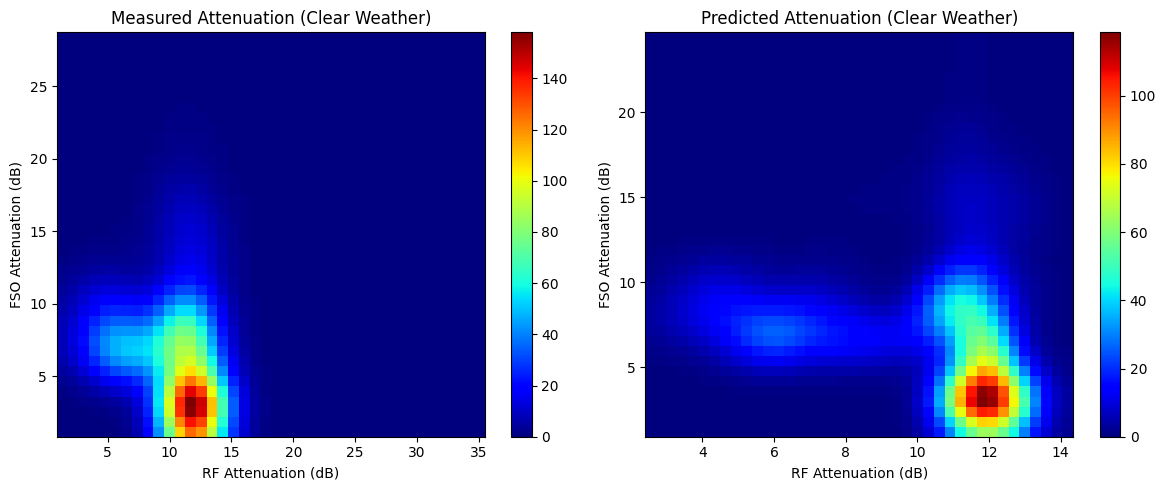

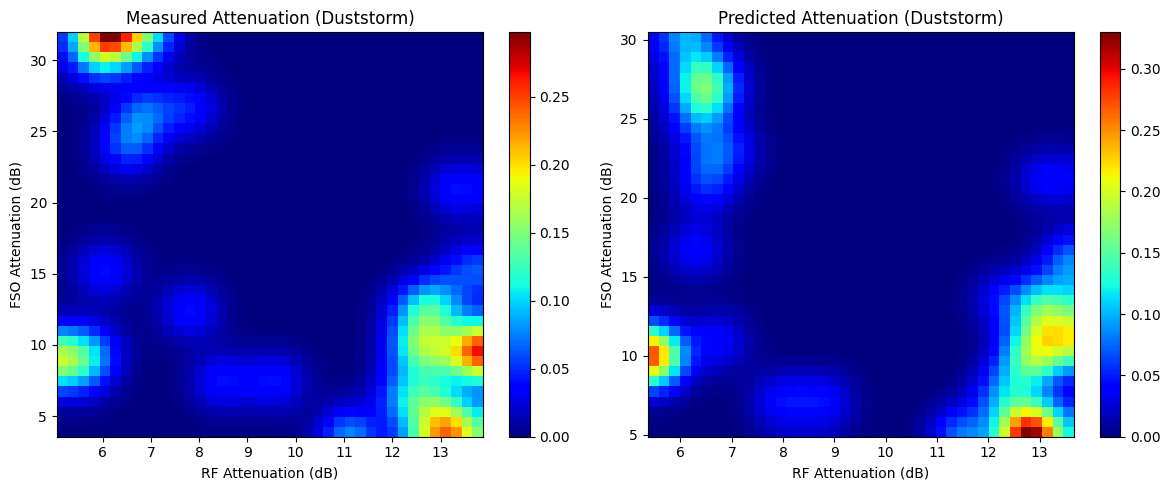

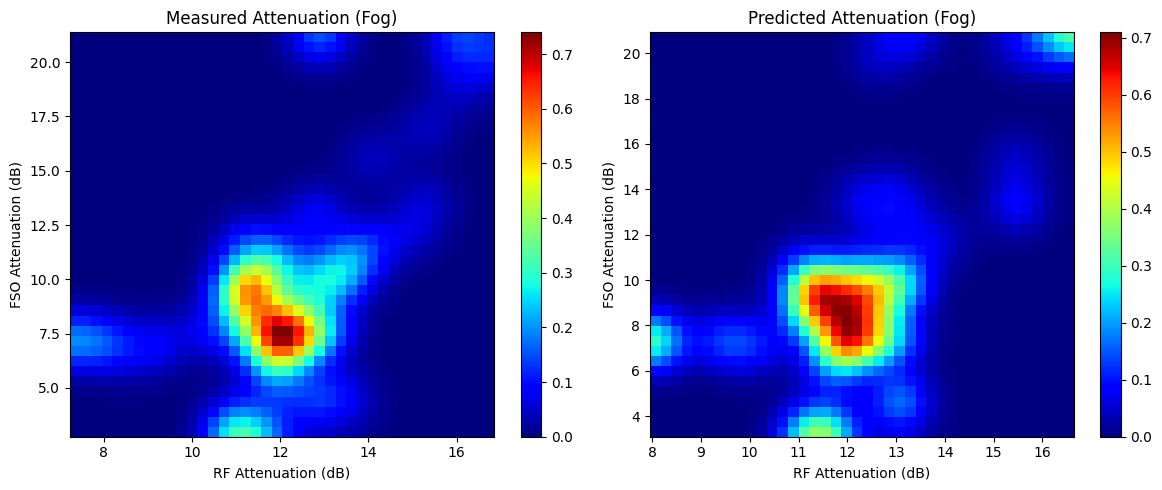

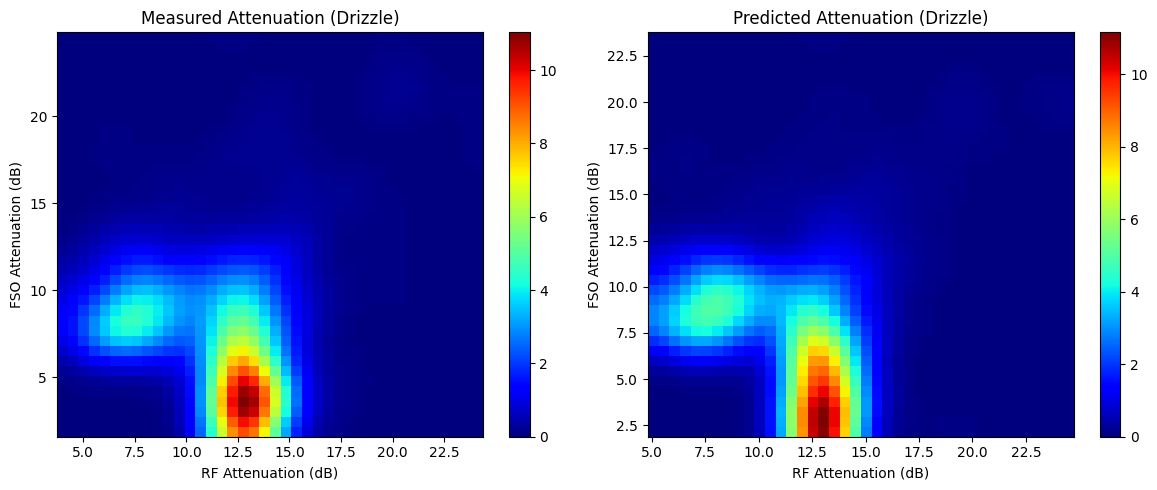

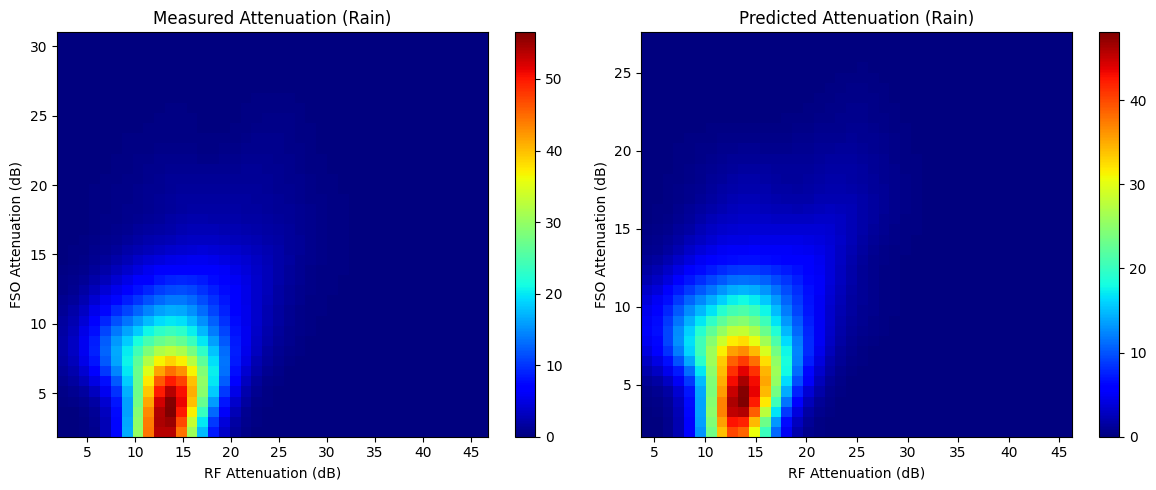

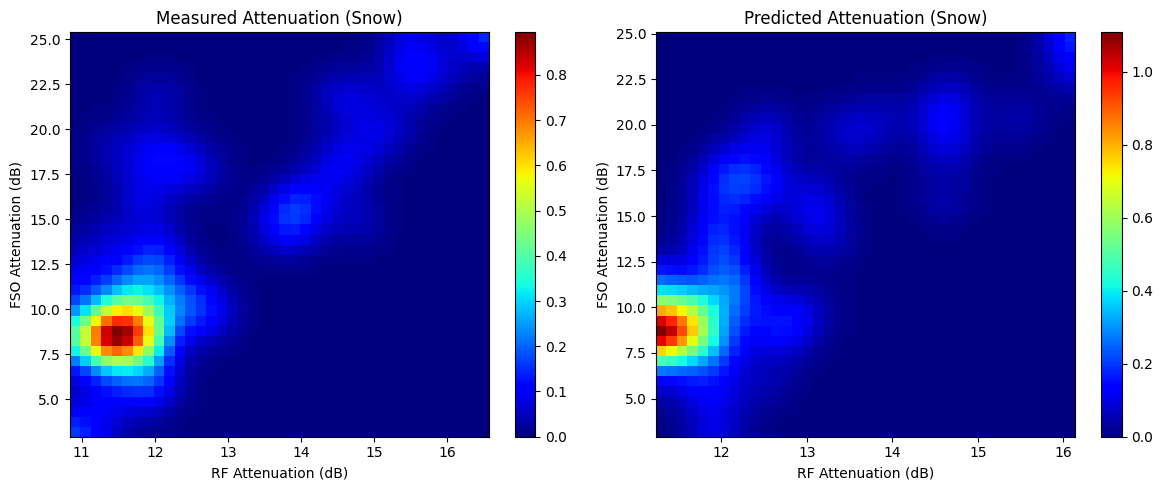

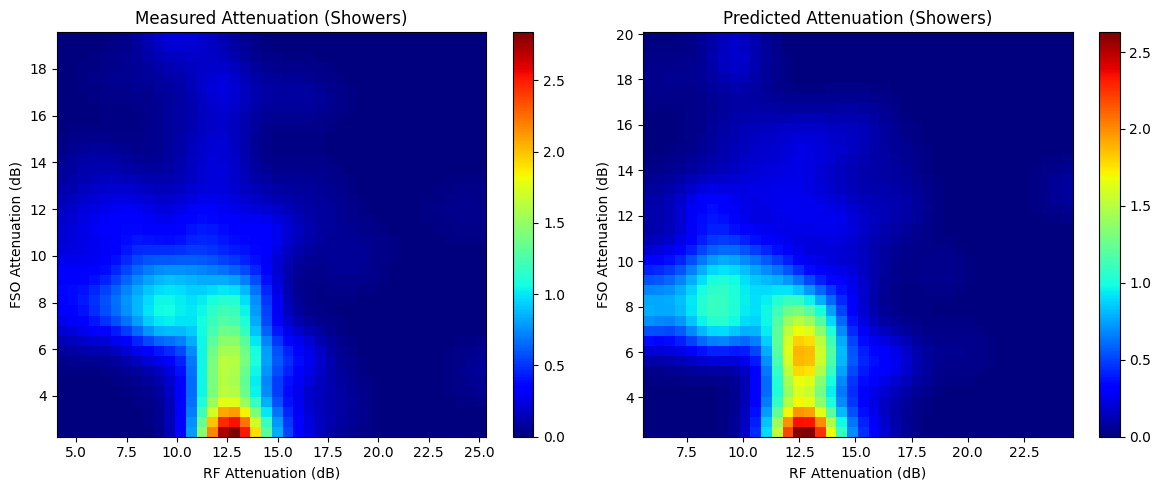

In [9]:
from scipy.stats import binned_statistic_2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np

def plot_measured_predicted_heatmaps_by_weather(predictions_by_weather, bin_size=40, sigma=1.2):
    for weather, preds in predictions_by_weather.items():
        rf_true = preds['rf_true']
        rf_pred = preds['rf_pred']
        fso_true = preds['fso_true']
        fso_pred = preds['fso_pred']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        def make_heatmap(ax, x, y, title):
            heatmap, xedges, yedges, _ = binned_statistic_2d(x, y, None, statistic='count', bins=bin_size)
            heatmap = np.nan_to_num(heatmap.T)
            heatmap_smoothed = gaussian_filter(heatmap, sigma=2.0)

            pcm = ax.imshow(
                heatmap_smoothed,
                origin='lower',
                cmap='jet',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                aspect='auto'
            )
            ax.set_title(title)
            ax.set_xlabel("RF Attenuation (dB)")
            ax.set_ylabel("FSO Attenuation (dB)")
            plt.colorbar(pcm, ax=ax)

        make_heatmap(axes[0], rf_true, fso_true, f"Measured Attenuation ({weather})")
        make_heatmap(axes[1], rf_pred, fso_pred, f"Predicted Attenuation ({weather})")

        plt.tight_layout()
        plt.show()



plot_measured_predicted_heatmaps_by_weather(heatmap_data, bin_size=40)




